Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" below:

In [1]:
NAME = "Binil Kuriachan"

---

## Convolutional Neural Networks

In the previous assignment, we have implemented a neural network using numpy. The goal of this assignment is to make you familiar with PyTorch and build a model in PyTorch using FashionMNIST data for Image classification. In this assignment we will build a Convolutional Neural Network that is better at extracting image features for classification.
 
**Note**: You can use Google Colab (https://colab.research.google.com/) for training with GPUs. You can also train the model using your local machine CPU or Coursera Jupyter Notebook similar to the previous assignments.

**Note**: The assignment will be graded offline - So, you would not be able to see the autograded scores at the end of your submission.

This assignment has two submissions


1.   The Python notebook submission on Coursera similar to previous assignments
2.   An HTML version of the completed assignment (You can download the HTML version from Jupyter Notebook on Coursera from the menu File > Download As > .html file) 



We first import the neccesary packages required to build the model. We will also set the seed for random generation in order to reproduce results through out the process to have a deterministic behaviour(reproduce same results) of the model. 

In [2]:
## Imports
## Mount the drive using the below imports while using google colab.
# from google.colab import drive
# drive.mount('/content/drive')

import os
import time
import numpy as np
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
# from tqdm import trange

# Checks for the availability of GPU 
if torch.cuda.is_available():
    print("working on gpu!")
    device = 'cuda'
else:
    print("No gpu! only cpu ;)")
    device = 'cpu'
    
# device = 'cpu'
    
## The following random seeds are just for deterministic behaviour of the code and evaluation

##############################################################################
################### DO NOT MODIFY THE CODE BELOW #############################    
##############################################################################

if device == 'cpu':    
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
elif device == 'cuda':
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = '0'

############################################################################### 


No gpu! only cpu ;)


### Arranging the data

In the following cell we will first download and re-structure the data. FashionMNIST dataset is already available in the official PyTorch repository.
You can find a detailed description of the dataset here: https://www.kaggle.com/zalando-research/fashionmnist 

The following cell checks for the availability of FashionMNIST data and downloads if the data is not available.   

The following parts are already written for you to handle the data.
- Import neccesary PyTorch packages for data handling.
- We then move the data onto PyTorch tensors.  
- Next we define the parameters like batch_size for data handling. A different batch_size for test data is used to make sure that number of samples in the test data are perfectly divisible.
- Create dataloaders for training and testing data to iterate.

In [3]:
import torchvision
import torchvision.transforms as transforms
import os

if not os.path.isdir('./data'):
    os.mkdir('./data')
root = './data/'

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize([0.5], [0.5]),
                             ])

training_data = torchvision.datasets.FashionMNIST(root, train=True, transform=transform,download=True)
testing_data = torchvision.datasets.FashionMNIST(root, train=False, transform=transform,download=True)

num_train = len(training_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_bs = 128
test_bs = 64

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(training_data, batch_size=train_bs,
    sampler=train_sampler, drop_last=False)
valid_loader = torch.utils.data.DataLoader(training_data, batch_size=train_bs, 
    sampler=valid_sampler, drop_last=False)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=test_bs, 
    drop_last=False)


### Peek into data

In the following cell we will visualize a few data samples from the dataset.

torch.Size([128, 1, 28, 28])


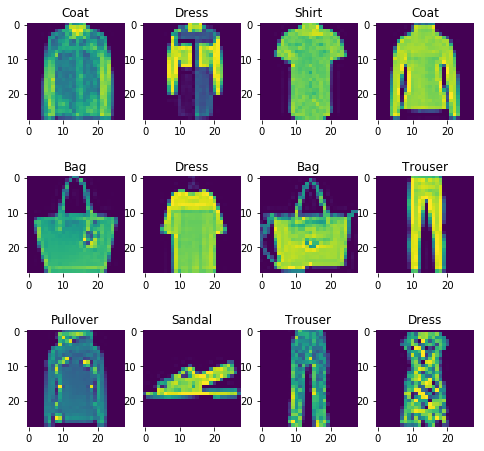

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## get a batch of data
images, labels = iter(train_loader).next()


image_dict = {0:'T-shirt/Top', 1:'Trouser', 2:'Pullover', 3:'Dress',
              4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker',
              8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8))

print(images.size())

for i in np.arange(1, 13):
    ax = fig.add_subplot(3,4,i, frameon=False)
    img = images[i][0]
    ax.set_title(image_dict[labels[i].item()])
    plt.imshow(img)


### Architecture

We implement a Convolutional Neural Network as our model. We make use of the following layers in our model.
- A convolution layer for extracting features.
- A batchnorm layer for normalizing the weights in the hidden layers.
- ReLU activation function for introducing non-linearity between layers.
- Finally, fully connected layers at the end.

#### Model:

Network Architecture

- A convolution layer number of output_channels-16, kernel_size=3, stride=1, padding-1
- batchnormalization layer
- ReLU activation layer
- A maxpool layer kernel_size=2, stride=2
- A convolution layer number of output_channels-32, kernel_size=3, stride=1, padding-1
- Batchnormalization layer
- ReLU activation layer
- Maxpool layer kernel_size=2, stride=2
- A convolution layer number of output_channels-64, kernel_size=3, stride=1, padding-1
- Batchnormalization layer
- ReLU activation layer
- A maxpool layer kernel_size=2, stride=2
- A fully connected layer - number_of_classes

![](images/cnn.png)

### Build the model

- We first define a class called Model.
- In init(constructor), we define all the layers that are used to build the model
- Finally, we define a sequential model in the forward function that takes in images as input and returns the predictions as output.

All the functions are available in the PyTorch package. Read the documentation/source code for a better understanding.

- Convolutional layer: https://pytorch.org/docs/stable/nn.html#convolution-layers
- Batchnorm layer: https://pytorch.org/docs/stable/nn.html#normalization-layers
- Activation ReLU: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
- Maxpooling layer: https://pytorch.org/docs/stable/nn.html#pooling-layers
- Fully connected layer: https://pytorch.org/docs/stable/nn.html#linear-layers



In [5]:
import torch.nn as nn

class Model(nn.Module):
    ## init function is the constructor and we define all the layers used in our model. 
    def __init__(self, num_classes=10):
        super(Model, self).__init__()
        ''' 
        REST OF THE MODEL HERE
        
        # define a convolutional layer with kernel_size=3, stride=1 and padding=1
        
        # define a batchnormalization layer 
        
        # define a relu layer.
        
        # define a maxpool layer.
        
        # define a convolutional layer with kernel_size=3, stride=1 and padding=1.
        
        # define a batchnormalization layer 
        
        # define a relu layer.
        
        # define a maxpool layer.
        
        # define a convolution layer with kernel_size=3, stride=1 and padding=1.
        
        # define a batchnorm layer.
        
        # define a relu layer.
        
        # define a maxpool layer.
        
        # define a fully connected layer from dimension -> number of classes.
        
        
        '''
        # YOUR CODE HERE
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1, stride = 1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride = 1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride = 1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(3*3*64, num_classes) 
#         raise NotImplementedError()
        
    def forward(self, x):
        # YOUR CODE HERE
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.max_pool2(x)
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.max_pool3(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
#         raise NotImplementedError()
        
    
        
        
        '''
        CODE HERE.
        
        # Note that before the fully connected(fc) layer, the output is a feature map with size (N,C,H,W)
        but a fully connected layer expects an input of size (N, dimension). so, before passing the output of
        maxpool layer to the fc layer, we must first flatten the output of previous layer to a size (N,C*H*W) 
        and then pass it to the fully connected layer.  
        
        To flatten the output of the layer before fc layer, pass it through the flatten function first and then 
        input it to the fully connected layer.
         
        '''
        
        return x
    
    def flatten(self, x):
        N, C, H, W = x.size()
        ## CODE HERE
        ## reshape x to (N, C*H*W) 
#         print(x.size())
        # YOUR CODE HERE
        x = x.view(N, C*H*W)
#         print(x.size())
#         raise NotImplementedError()
#         x = None
        
        return x
        
        
    

In [6]:
## Run the cell to check the implementation of your model
model = Model(num_classes=10)
test_input = torch.randn(16,1,28,28)
out = model(test_input)
test_input2 = torch.rand(16,1,28,28)
out2 = model(test_input2)



In [7]:
## Hyperparameters for training the model.

learning_rate = 0.0001
epochs = 7
number_of_classes = 10

Define a loss criterion:
We will use cross-entropy loss between the predictions and ground truth to estimate the loss. 
- CrossEntropyLoss - https://pytorch.org/docs/stable/nn.html#crossentropyloss

We also define an optimization strategy to update the weights. We use the commonly used Adam optimizer from the PyTorch package.

- Adam - https://pytorch.org/docs/stable/optim.html#algorithms 

In [8]:
## First we will define an instance of the model to train
model = Model(num_classes=number_of_classes)
model = model.to(device)

# define the loss
# YOUR CODE HERE
# raise NotImplementedError()
# criterion = None
criterion = nn.CrossEntropyLoss();

# optimizer for the model, here we use Adam optimizer with a learning rate=0.001, momentum as 0.9
# and nesterov True.  
# YOUR CODE HERE
# raise NotImplementedError()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), amsgrad = True);

# optimizer = None

In [9]:
out = torch.FloatTensor([[0.1,0.8,0.05,0.05]])
true = torch.LongTensor([1])
assert criterion(out, true), 0.8925

The training loop is setup in the following way:

For every batch in the given number of epochs

- Move the images and labels to the device
- Extract outputs by passing images as input.
- pass the output and ground truth labels to the loss criterion for batch loss
- clear the gradients 
- backpropagate (compute gradients w.r.t the parameters)
- update the parameters with a single optimization step
- update the training loss for plots

repeat

In [10]:
## training loop 

## Number of epochs the model runs

def train_model(epochs=25, validate=True):
    '''
    A function to train the model on the dataset and returns the trained model, training loss and
    validation loss for every epoch.
    
    Inputs:
        epochs: Number of times the model should be trained on the whole data.
        validate: A boolean parameter that validates on validation data.
        
    outputs:
        model: The model trained for specified number of epochs
        training loss: A list of training losses computed for every epoch.
        validation loss: A list of validation losses computed for every epoch.
    
    '''
    train_loss = []
    val_loss = []
    total_tr_batches = 0
    total_val_batches = 0

    for epoch in range(epochs):
        # Iterate through the batches in the data
        training_loss = 0.0
        validation_loss = 0.0
#         print("***************")

        model.train()
    #     for (images,labels)  in trange(train_loader, leave=False):
        for (images,labels)  in train_loader:
            # YOUR CODE HERE
#             raise NotImplementedError()
            '''
            CODE HERE
            '''           

            ## Move the images to the device
#             images = images.reshape(-1, 28*28)
            images = images.to(device)

            ## Move the labels to the device
            labels = labels.to(device)

            ## Get the output of the model by passing input to the model
            outputs = model(images)

            ## Find the loss of the input batch by passing output & ground truth labels to the criterion
            loss = criterion(outputs, labels)
#             print(loss)
            training_loss = training_loss + loss.item()
            total_tr_batches += 1
            

            ## clear the gradients
            optimizer.zero_grad()

            ## compute the gradients by backpropagating through the computational graph.
            loss.backward()

            ## update the parameters 
            optimizer.step()
            
        train_loss.append(training_loss/total_tr_batches)
        print('train loss', training_loss/total_tr_batches)
        
        if validate == True:
            model.eval()
    #     for (images,labels)  in trange(train_loader, leave=False):
            for (images,labels)  in valid_loader:
                # YOUR CODE HERE
    #             raise NotImplementedError()
                '''
                CODE HERE
                '''

                ## Move the images to the device
    #             images = images.reshape(-1, 28*28)
                images = images.to(device)

                ## Move the labels to the device
                labels = labels.to(device)

                ## Get the output of the model by passing input to the model
                outputs = model(images)

                ## Find the loss of the input batch by passing output & ground truth labels to the criterion
                loss = criterion(outputs, labels)
                validation_loss = validation_loss + loss.item()
                total_val_batches += 1

                ## clear the gradients
#                 optimizer.zero_grad()

        val_loss.append(validation_loss/total_val_batches)
        print("Validation loss ",validation_loss/total_val_batches)

               
    return model, train_loss, val_loss
                

In [11]:
start = time.time()
trained_model, train_loss, val_loss = train_model(epochs, validate=True)
end = time.time()
print(end - start)

train loss 0.8796584072907766
Validation loss  0.5469641209916866
train loss 0.23449607117970783
Validation loss  0.21152011701401244
train loss 0.12925037643644544
Validation loss  0.12387434419587995
train loss 0.0861835422317187
Validation loss  0.08540089662246247
train loss 0.06358149936993916
Validation loss  0.06488851207367917
train loss 0.04947120749950409
Validation loss  0.05157708767669421
train loss 0.04018760402429671
Validation loss  0.04346805985303635
1531.3802604675293


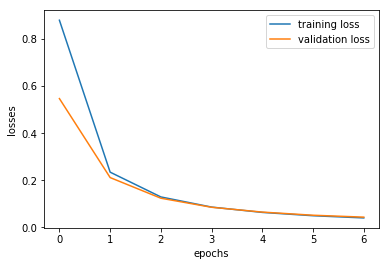

In [12]:
# Plot the losses
it = np.arange(epochs)
plt.plot(it, train_loss, label='training loss')
plt.plot(it, val_loss, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(loc='upper right')
plt.show()

### Testing Loop

During Testing, we don't update the model weights. The trained model is tested for all the samples in test data to compute the accuracy and observe how well the model is generalizing to the unseen data. 

The testing loop is setup in the following way: 

For every batch in the testing data:

- Put the model in the evaluation mode and turn off the gradients
- Move the images and labels to the device
- Extract output from the model for the input
- Compute the prediction class by choosing the one with maximum probability in the predictions.
- Compare the prediction classes with true classes.
- Calculate accuracy
- Update test_loss for plots

repeat


In [14]:
## Testing Loop

def test_model(model):
    '''
    A function to test the trained model on the test dataset and print the accuracy.
    
    Inputs:
        model: Trained model.
        
    outputs:
        None. Prints the accuracy.
    '''
    model.eval()
    with torch.no_grad():
        correct = 0.0
        total_samples = 0.0
        for images, labels in test_loader:
            
            # YOUR CODE HERE
#             raise NotImplementedError()
            '''
            YOUR CODE HERE
            '''
            ## Move the images to the device
            images = images.to(device)

            ## Move the labels to the device
            labels = labels.to(device)

            ## Get the output of the model by passing images as input to the model
            outputs = model(images)

            ## convert the outputs to a probability distribution using softmax and 
            softmax= nn.Softmax(dim=1)
            outputs = softmax(outputs)

            ## find the prediction with maximum probability
            predicted = torch.argmax(outputs,dim=1)

            ## compare predictions with ground truth for number of correct samples
            correct += (predicted == labels).sum().item()

            total_samples += labels.size(0)
        
        accuracy = (correct/total_samples)*100
        print("Total Accuracy on the Test set: {} %".format(accuracy))
        return accuracy
    
        
test_model(model)
    

Total Accuracy on the Test set: 88.25 %


88.25

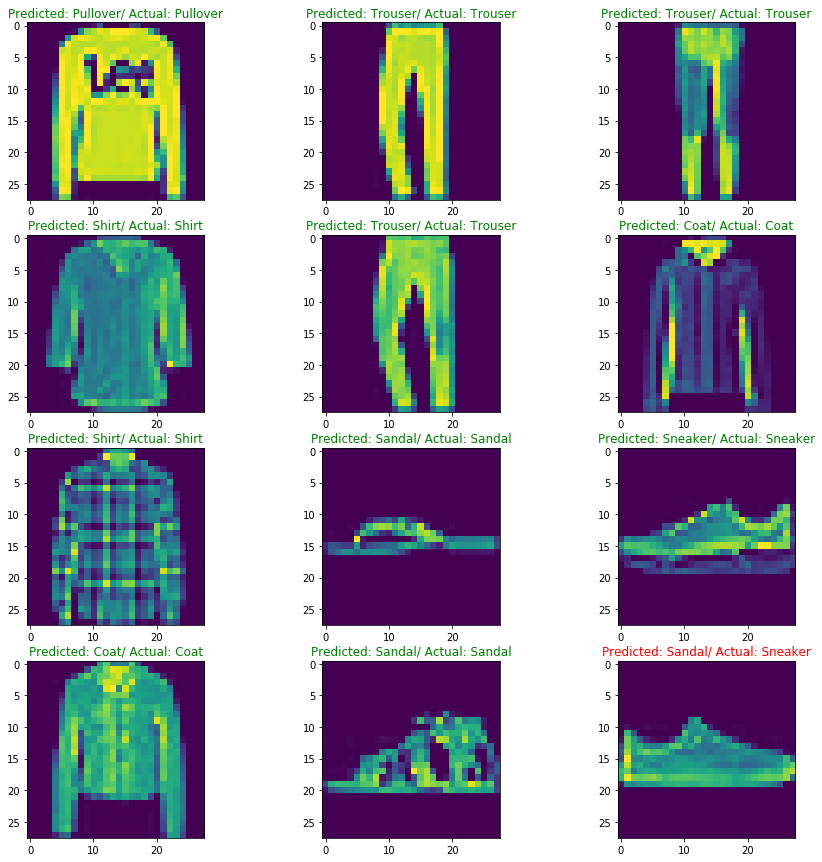

In [15]:
## Visualize the test samples with predicted output and true output
images, labels = iter(test_loader).next()
# images = images.numpy()
images = images.to(device)
labels = labels.to(device)

out = model(images)
_, preds = torch.max(out, dim=1)

fig = plt.figure(figsize=(15,15))
for i in np.arange(1, 13):
    images = images.cpu().float()
    ax = fig.add_subplot(4, 3, i)
    plt.imshow(images[i][0])
    ax.set_title("Predicted: {}/ Actual: {}".format(image_dict[preds[i].item()], image_dict[labels[i].item()]), 
                color=('green' if preds[i] == labels[i] else 'red'))